In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from user_profile_segmentation.data.custom import capitalize_and_replace, read_csv_from_minio, mutual_info, trustworthiness

In [2]:
df = read_csv_from_minio(bucket_name="data", object_name="users_data.csv")
df

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:user_profile_segmentation.data.custom:Successfully loaded CSV data from 'users_data.csv' in bucket 'data'.


,user_id,loan_score,device_rating,data_quality,ltv_rate,bureau_score,total_tenure,months_active,savings_score,tx_score,usage_score,airtime_score,cluster
0,146245,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,NaN
1,248802,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,NaN
2,13873,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,NaN
3,35230,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,NaN
4,653322,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,484287,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,NaN
1595,395421,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,NaN
1596,341145,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,NaN
1597,587504,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,NaN


# Data Investigation

Investigating the shape of the dataset

In [3]:
df.shape

(1599, 13)

Investigating the data types of the features of the dataset

In [4]:
df.dtypes

user_id            int64
loan_score       float64
device_rating    float64
data_quality     float64
ltv_rate         float64
bureau_score     float64
total_tenure     float64
months_active    float64
savings_score    float64
tx_score         float64
usage_score      float64
airtime_score    float64
cluster          float64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        1599 non-null   int64  
 1   loan_score     1599 non-null   float64
 2   device_rating  1599 non-null   float64
 3   data_quality   1599 non-null   float64
 4   ltv_rate       1599 non-null   float64
 5   bureau_score   1599 non-null   float64
 6   total_tenure   1599 non-null   float64
 7   months_active  1599 non-null   float64
 8   savings_score  1599 non-null   float64
 9   tx_score       1599 non-null   float64
 10  usage_score    1599 non-null   float64
 11  airtime_score  1599 non-null   float64
 12  cluster        0 non-null      float64
dtypes: float64(12), int64(1)
memory usage: 162.5 KB


Investigating for the presence of null values 

In [6]:
df.isnull().sum()

user_id             0
loan_score          0
device_rating       0
data_quality        0
ltv_rate            0
bureau_score        0
total_tenure        0
months_active       0
savings_score       0
tx_score            0
usage_score         0
airtime_score       0
cluster          1599
dtype: int64

Determining the cardinality (number of unique values) for all features

In [7]:
df.nunique().sort_values(ascending=False)

user_id          1599
savings_score     436
bureau_score      153
months_active     144
device_rating     143
loan_score         96
usage_score        96
ltv_rate           91
tx_score           89
data_quality       80
airtime_score      65
total_tenure       60
cluster             0
dtype: int64

Descriptive statistics of the dataset

In [8]:
df.describe(include="all")

,user_id,loan_score,device_rating,data_quality,ltv_rate,bureau_score,total_tenure,months_active,savings_score,tx_score,usage_score,airtime_score,cluster
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,0.0
mean,397669.085679,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,NaN
std,228348.459331,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,NaN
min,1449.000000,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,NaN
25%,196569.500000,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,NaN
50%,398366.000000,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,NaN
75%,592184.000000,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,NaN
max,798882.000000,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,NaN


In [9]:
df_copy = df.copy()

Investigating the number of duplicated rows

In [10]:
print('Duplicated Rows: %s'%df_copy.duplicated().sum())

Duplicated Rows: 0


In [11]:
df["data_quality"]

0       0.00
1       0.00
2       0.04
3       0.56
4       0.00
        ... 
1594    0.08
1595    0.10
1596    0.13
1597    0.12
1598    0.47
Name: data_quality, Length: 1599, dtype: float64

# Exploratory Data Analysis (EDA)

## Univariate Analysis

### Frequency Distribution of Continuous Features

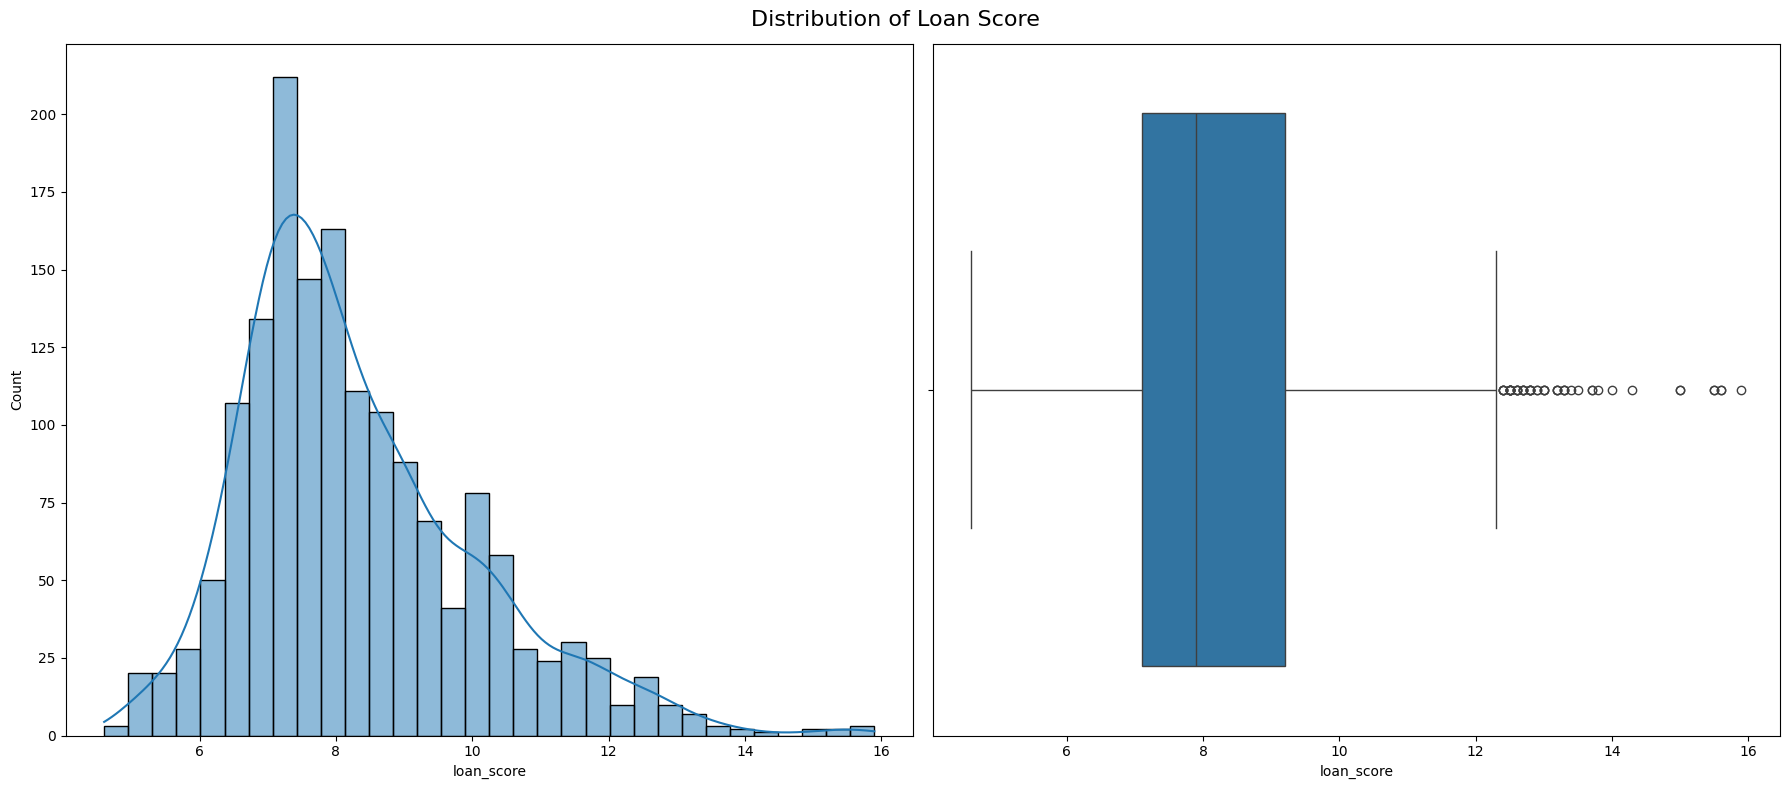

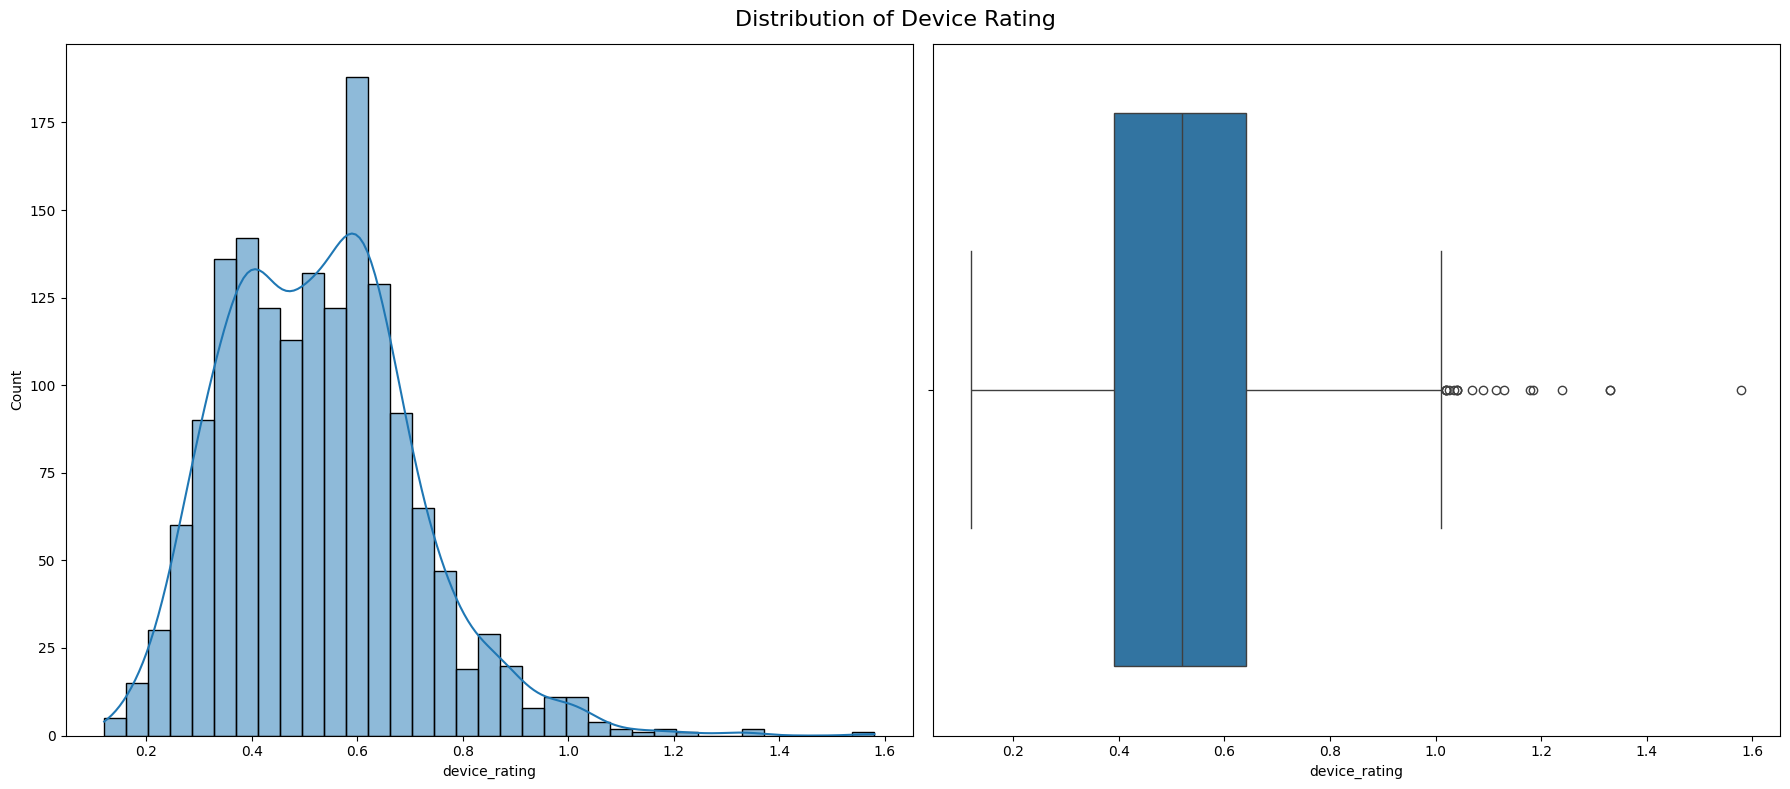

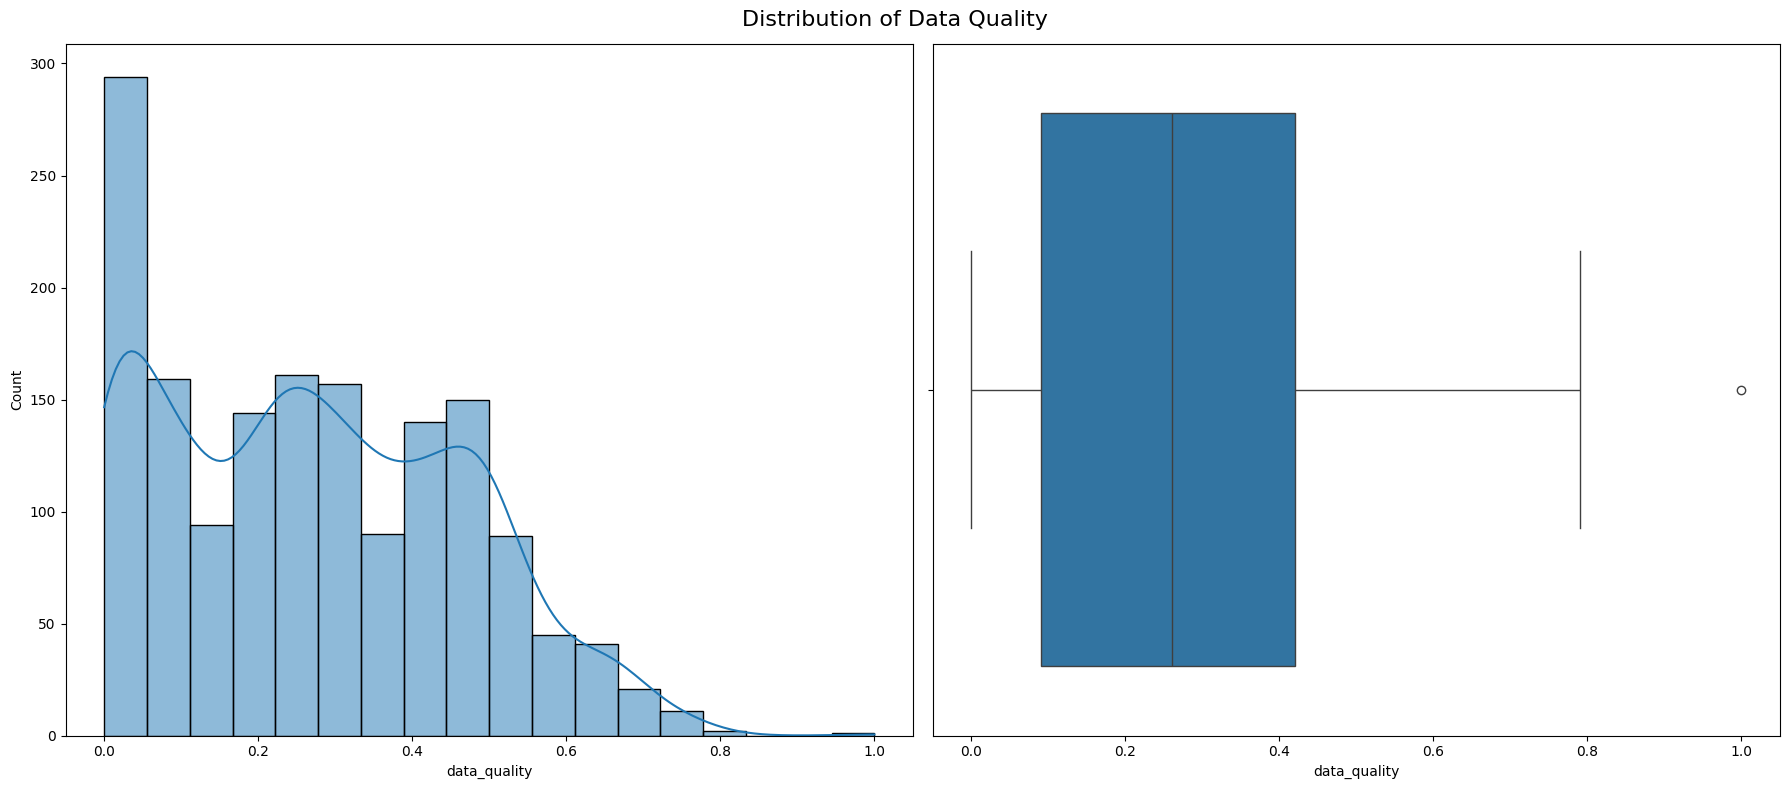

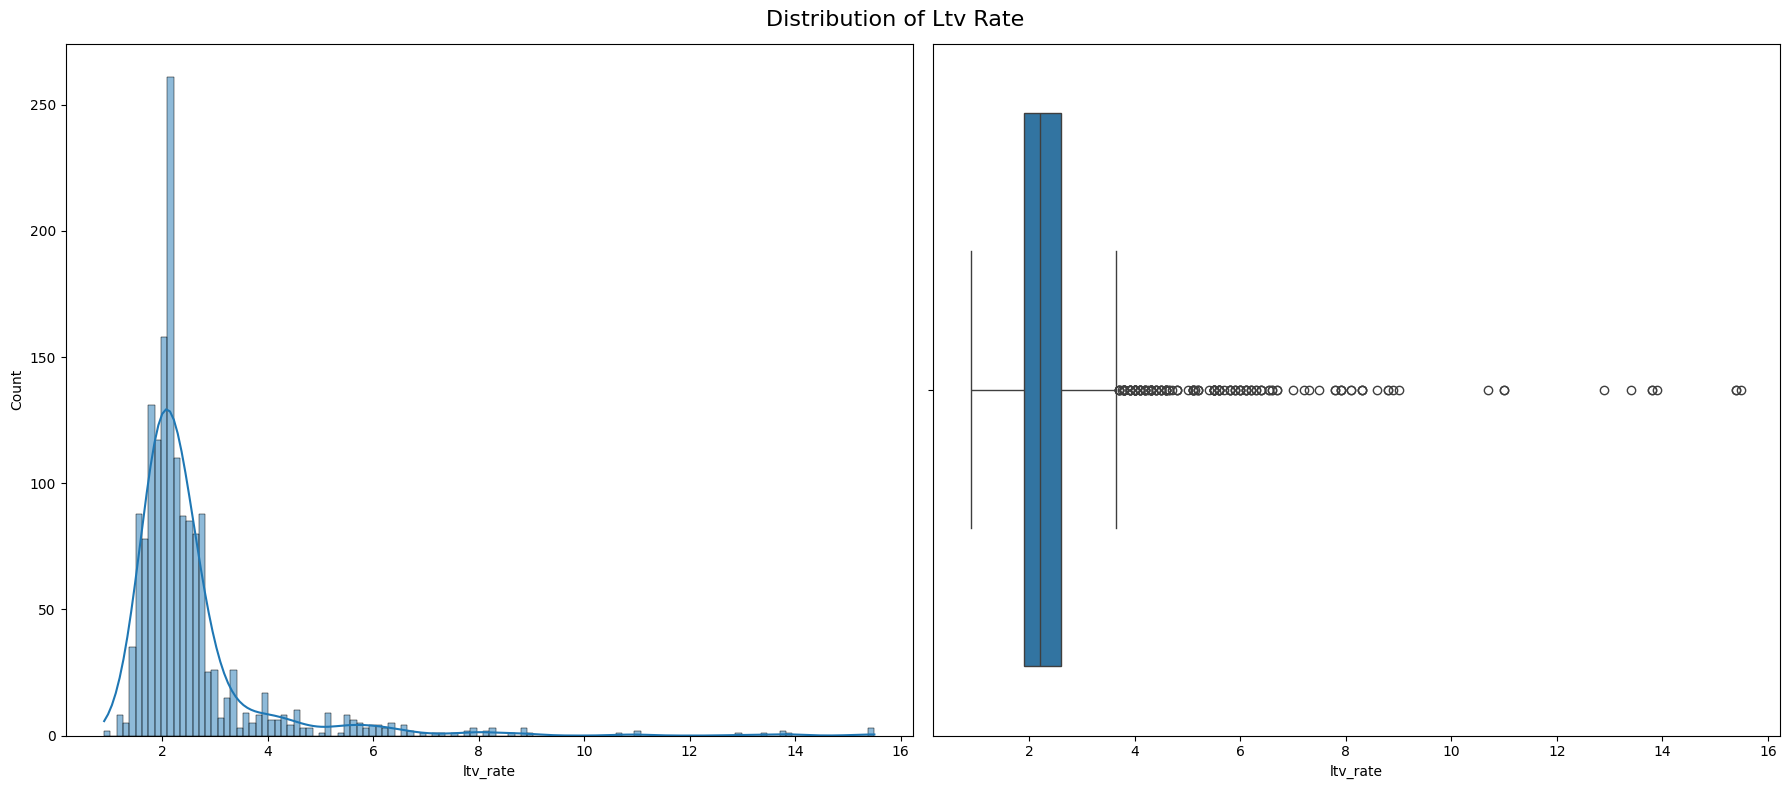

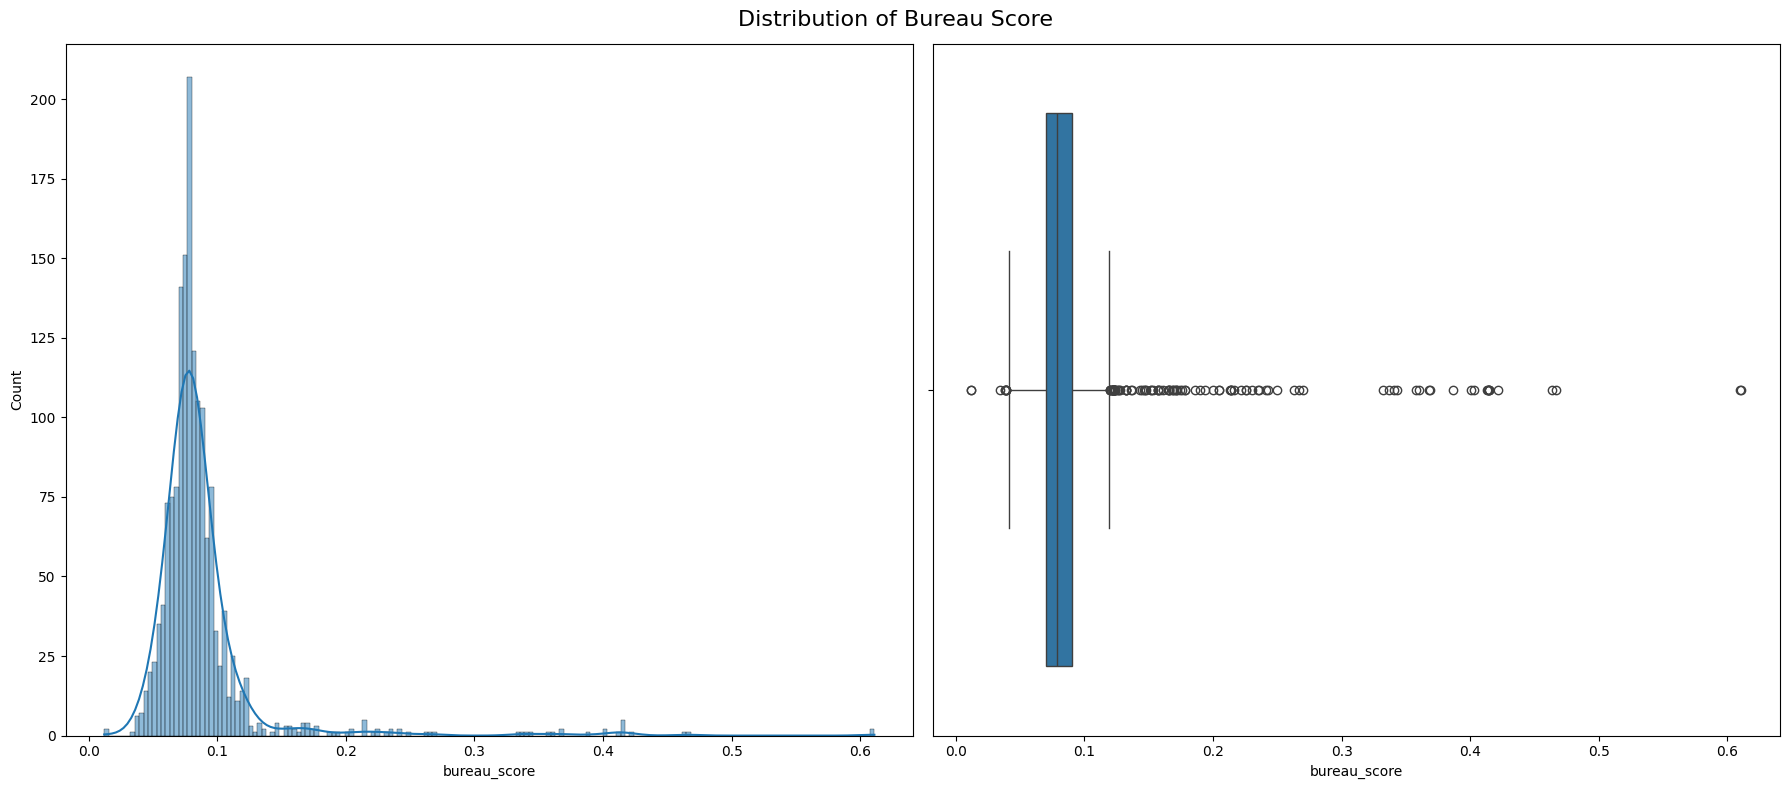

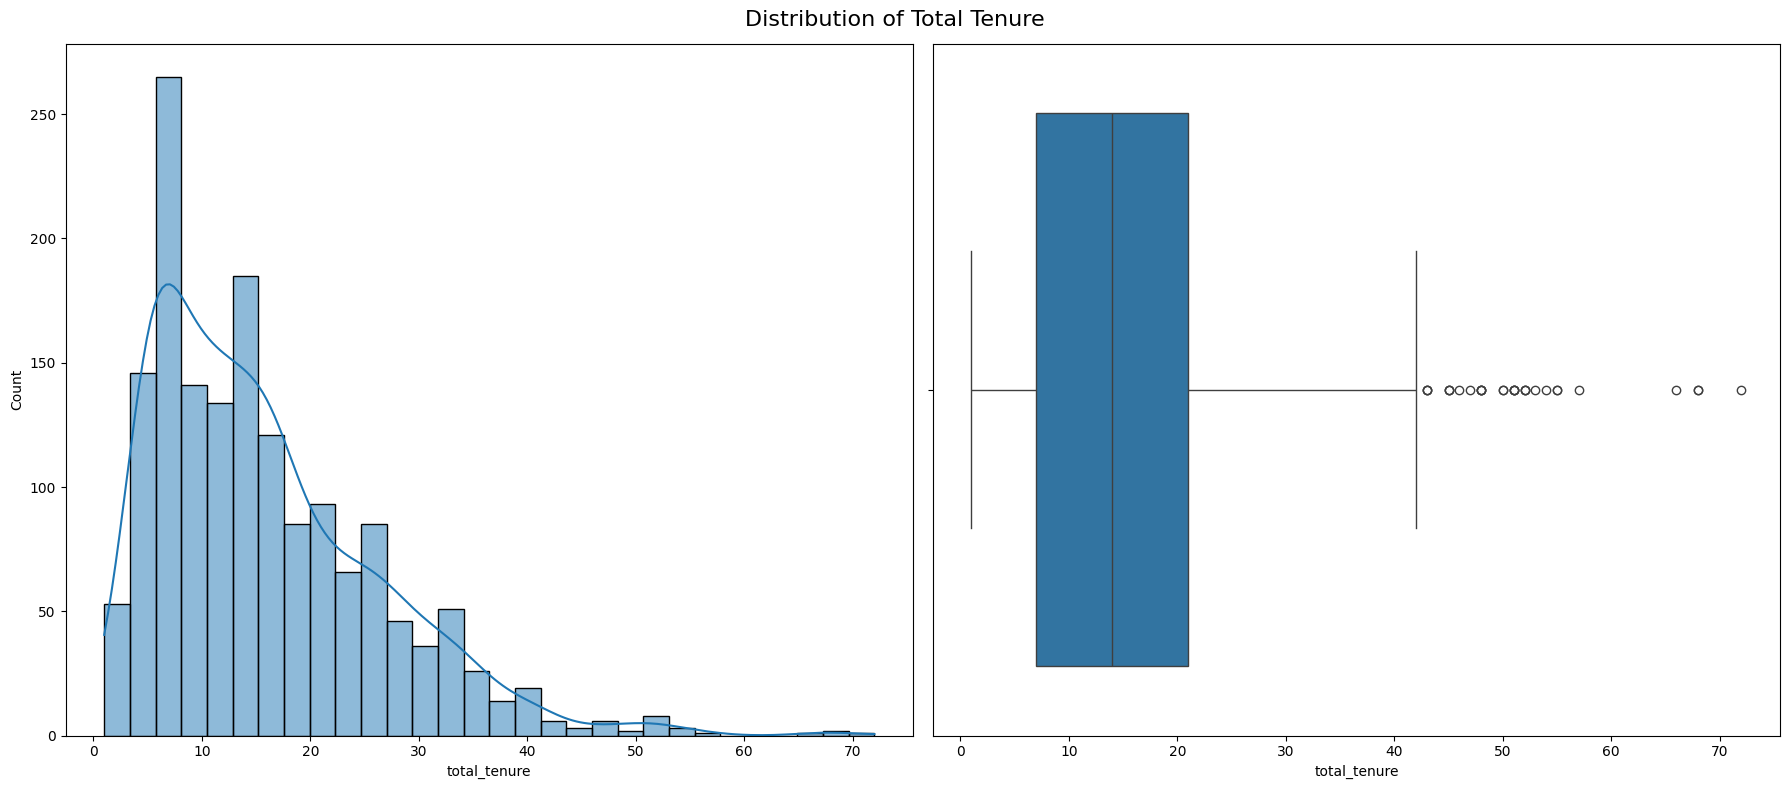

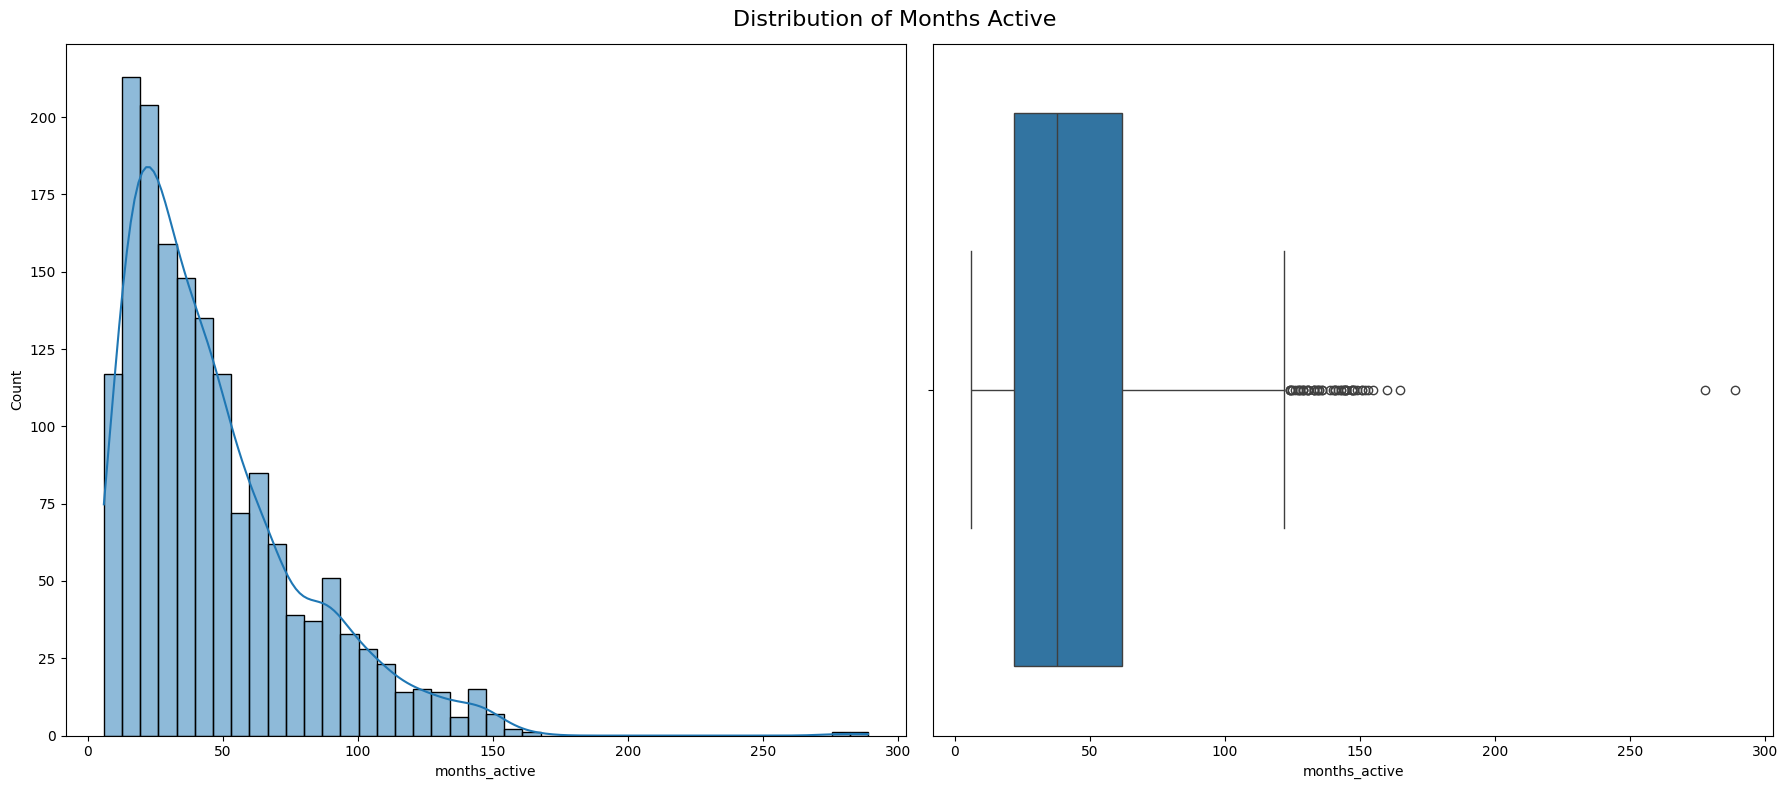

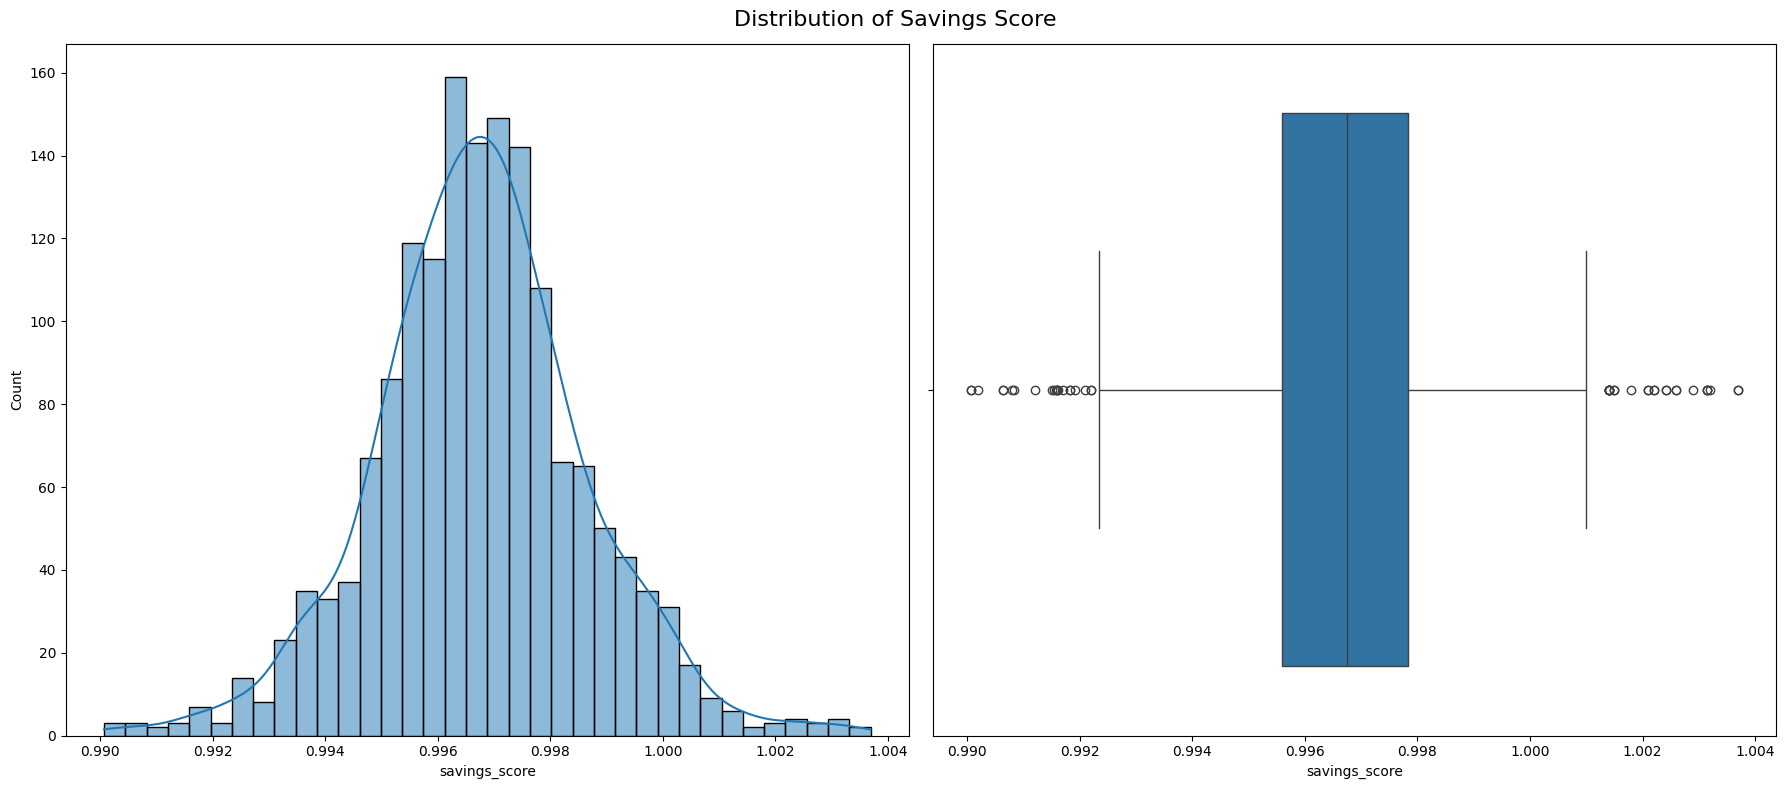

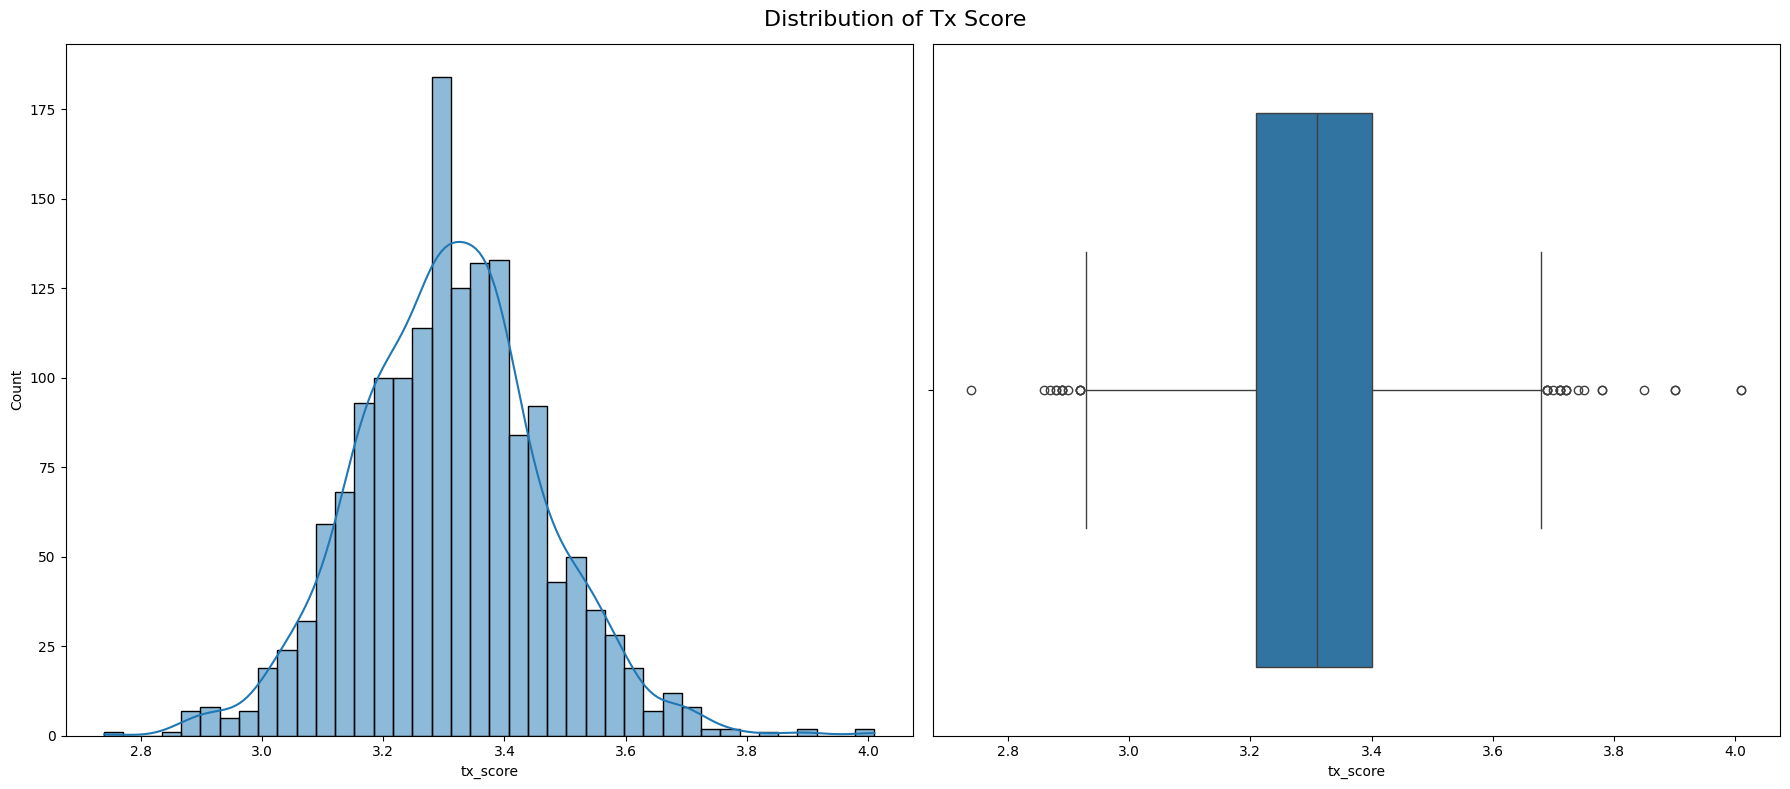

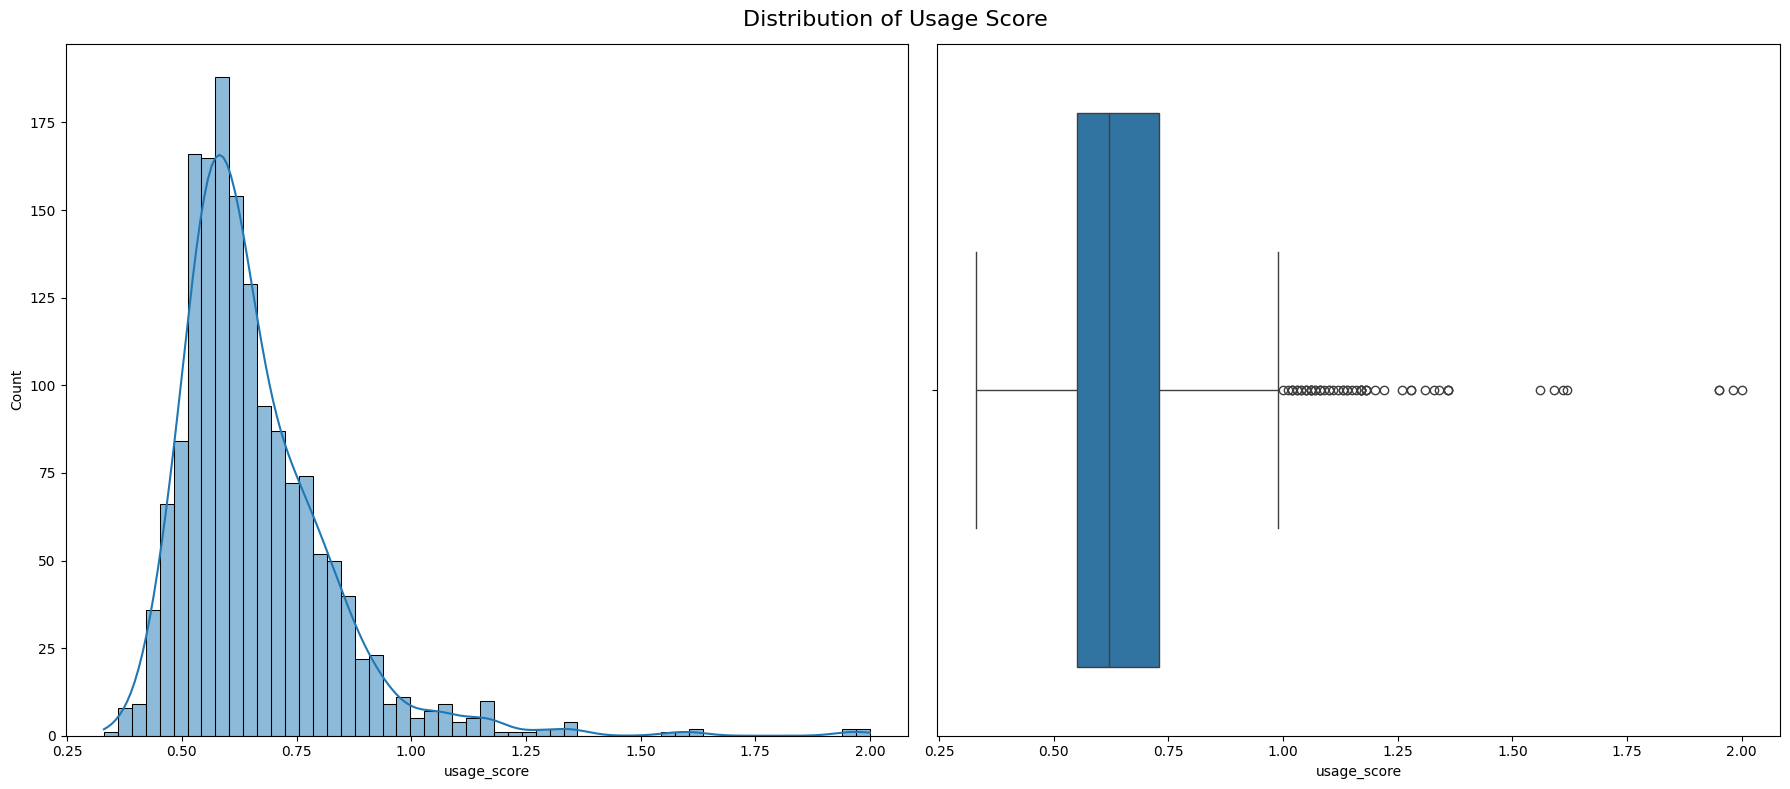

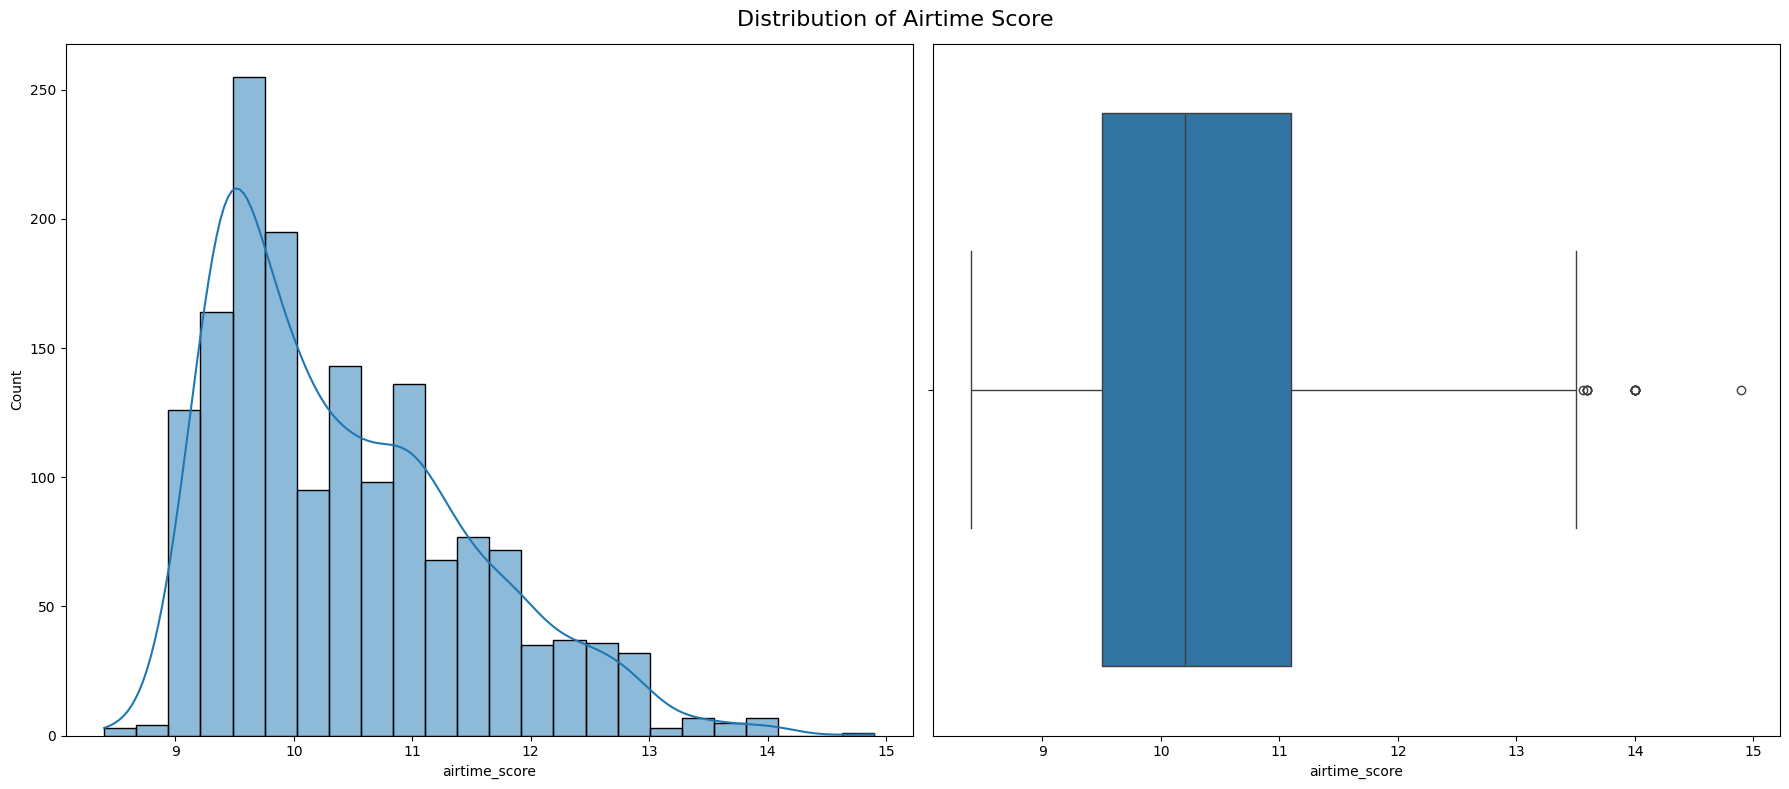

In [12]:
features = [column for column in df_copy.columns if column not in ["user_id", "cluster"]]


for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    fig.suptitle(f"Distribution of {capitalize_and_replace(feature, '_')}", fontsize=16)
    sns.histplot(data=df_copy, x=feature, kde=True, ax=axes[0])
    sns.boxplot(data=df_copy, x=feature, ax=axes[1])
    plt.tight_layout()
    plt.show()

Investigating the features for the presence of sparsity

In [13]:
results = []

for feature in features:
    zero_values = df_copy[feature] == 0
    zero_count = zero_values.sum()
    total_rows = df_copy.shape[0]
    zero_percentage = (zero_count / total_rows) * 100

    results.append({
        "Feature": feature,
        "Total_Rows": total_rows,
        "Zero_Count": zero_count,
        "Zero_Percentage": zero_percentage,
    })

sparsity_df = pd.DataFrame(results)
sparsity_df

,Feature,Total_Rows,Zero_Count,Zero_Percentage
0,loan_score,1599,0,0.000000
1,device_rating,1599,0,0.000000
2,data_quality,1599,132,8.255159
3,ltv_rate,1599,0,0.000000
4,bureau_score,1599,0,0.000000
5,total_tenure,1599,0,0.000000
6,months_active,1599,0,0.000000
7,savings_score,1599,0,0.000000
8,tx_score,1599,0,0.000000
9,usage_score,1599,0,0.000000


## Bivariate Analysis

### Correlation Heatmap of Continuous Features

#### Pearson's Correlation on processed dataset

Dropping the "user_id" and "cluster" features as a preliminary preprocessing step

In [14]:
df_copy_trimmed = df_copy.drop(columns=["user_id", "cluster"])

In [15]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_copy_trimmed)
df_copy_scaled = pd.DataFrame(scaled_data, columns=df_copy_trimmed.columns)

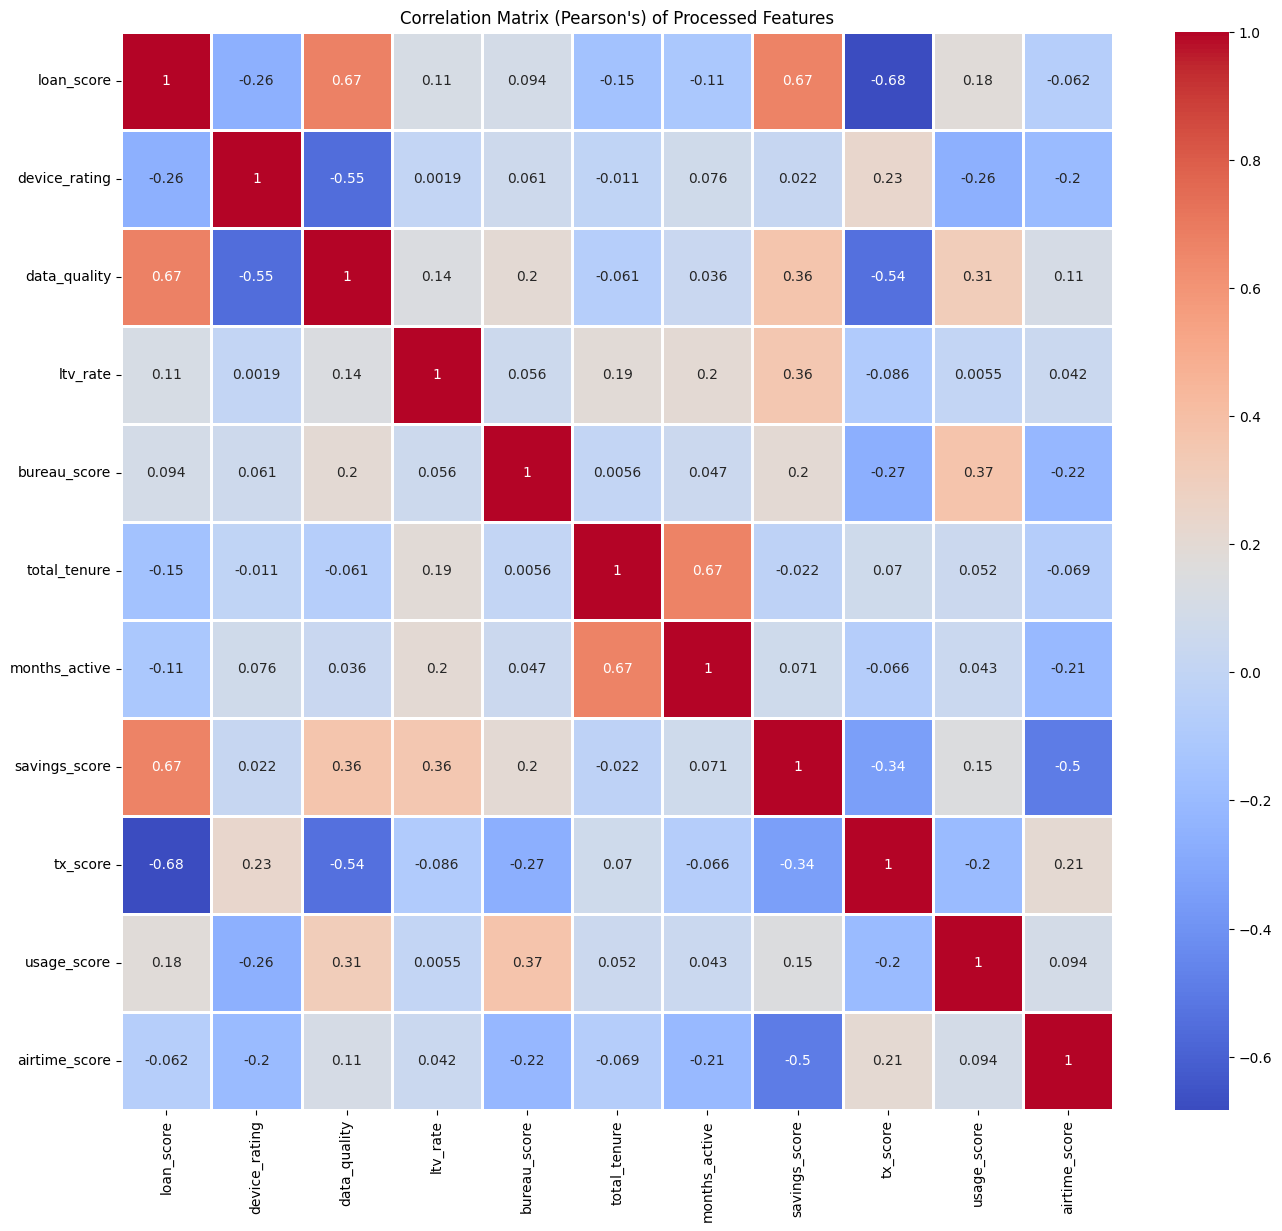

In [16]:
pearson_corr = df_copy_scaled.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(pearson_corr, annot=True, linewidths=1, cmap="coolwarm")
plt.title("Correlation Matrix (Pearson's) of Processed Features")
plt.show()

#### Spearman's Rank Correlation on unprocessed dataset

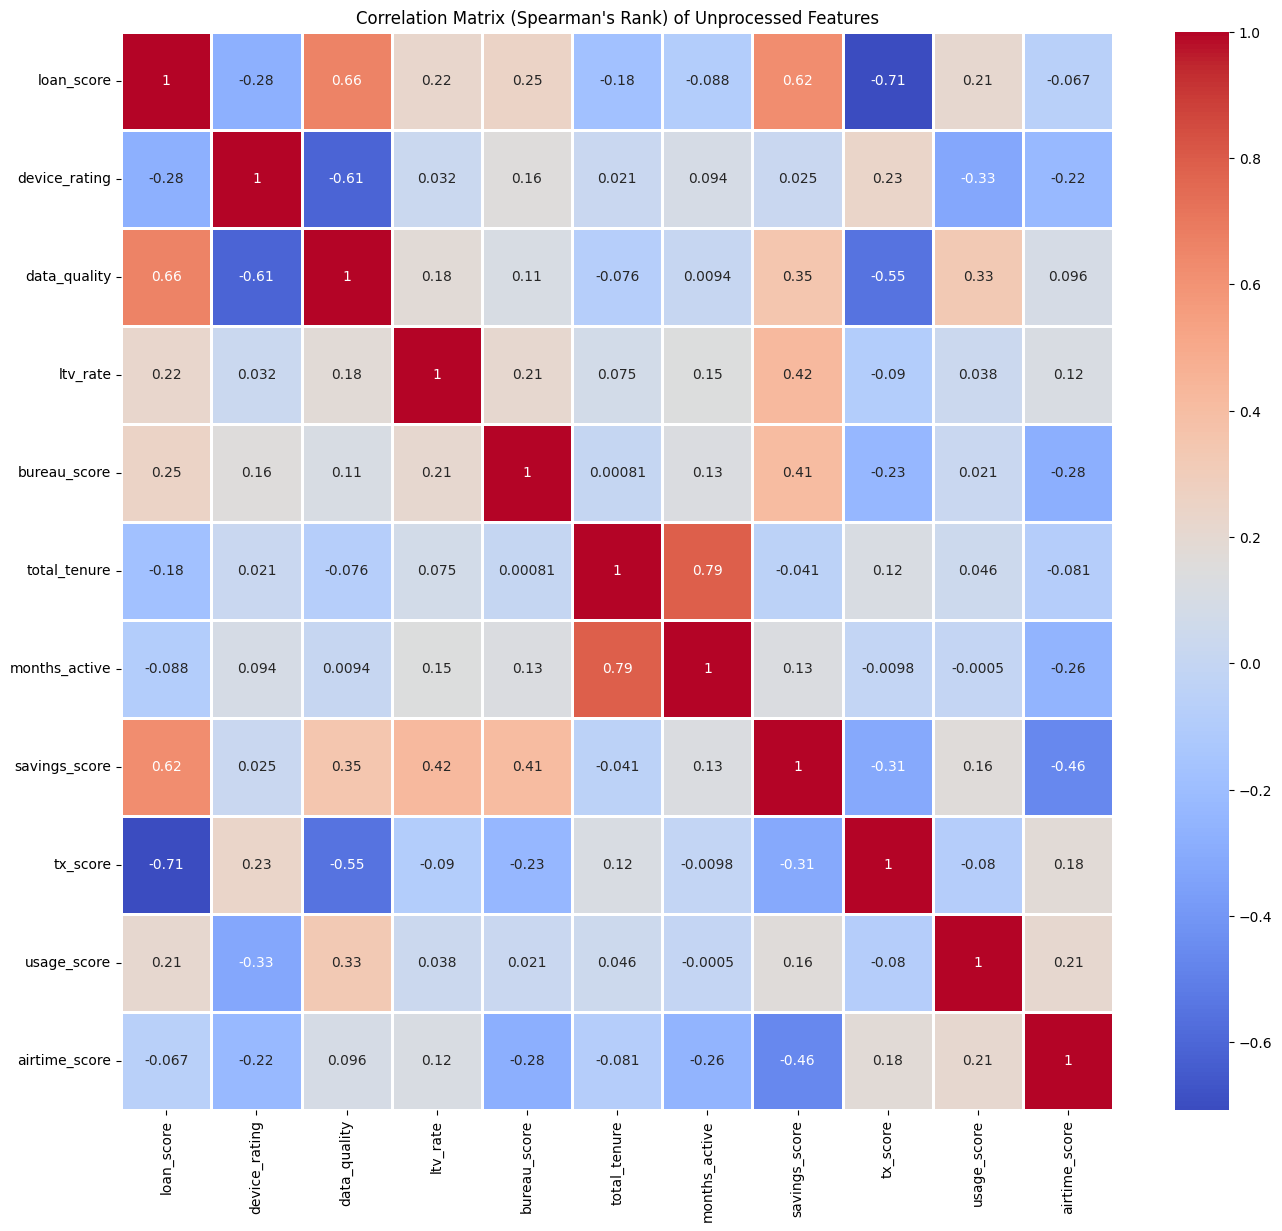

In [17]:
spearman_corr = df_copy_trimmed.corr(method="spearman")
plt.figure(figsize=(16, 14))
sns.heatmap(spearman_corr, annot=True, linewidths=1, cmap="coolwarm")
plt.title("Correlation Matrix (Spearman's Rank) of Unprocessed Features")
plt.show()

### Mutual Information Analysis of Continuous Features

In [18]:
mi_matrix = mutual_info(df_copy_trimmed)

In [19]:
mi_matrix

,loan_score,device_rating,data_quality,ltv_rate,bureau_score,total_tenure,months_active,savings_score,tx_score,usage_score,airtime_score
loan_score,0,0.051748,0.332726,0.044211,0.005481,0,0.041745,0.32958,0.350118,0.066493,0.081978
device_rating,0.035329,0,0.227511,0.006939,0.043856,0.016827,0.048011,0.005049,0.03372,0.064624,0.030153
data_quality,0.288438,0.213154,0,0,0.037722,0.033013,0.050319,0.111881,0.162586,0.052537,0.043461
ltv_rate,0.033427,0.040338,0.040262,0,0.025959,0.028516,0.010492,0.083723,0,0.033694,0.002891
bureau_score,0.040291,0.023852,0.030536,0.028376,0,0.023957,0,0.104886,0.032653,0.060535,0.070476
total_tenure,0.005723,0,0.023244,0.0307,0.00764,0,0.312222,0.023841,0.01378,0.008534,0.036581
months_active,0.044569,0,0.024195,0.055654,0,0.308381,0,0.030732,0.068351,0.013331,0.05312
savings_score,0.296001,0.010852,0.111908,0.077035,0.083209,0.023347,0.022696,0,0.05295,0.033889,0.201384
tx_score,0.283864,0.030384,0.157513,0.008556,0.033762,0.001852,0.027477,0.086602,0,0.047299,0.044363
usage_score,0.033458,0.056039,0.053196,0.00482,0.042988,0.021935,0.02521,0.036589,0.025355,0,0.018342


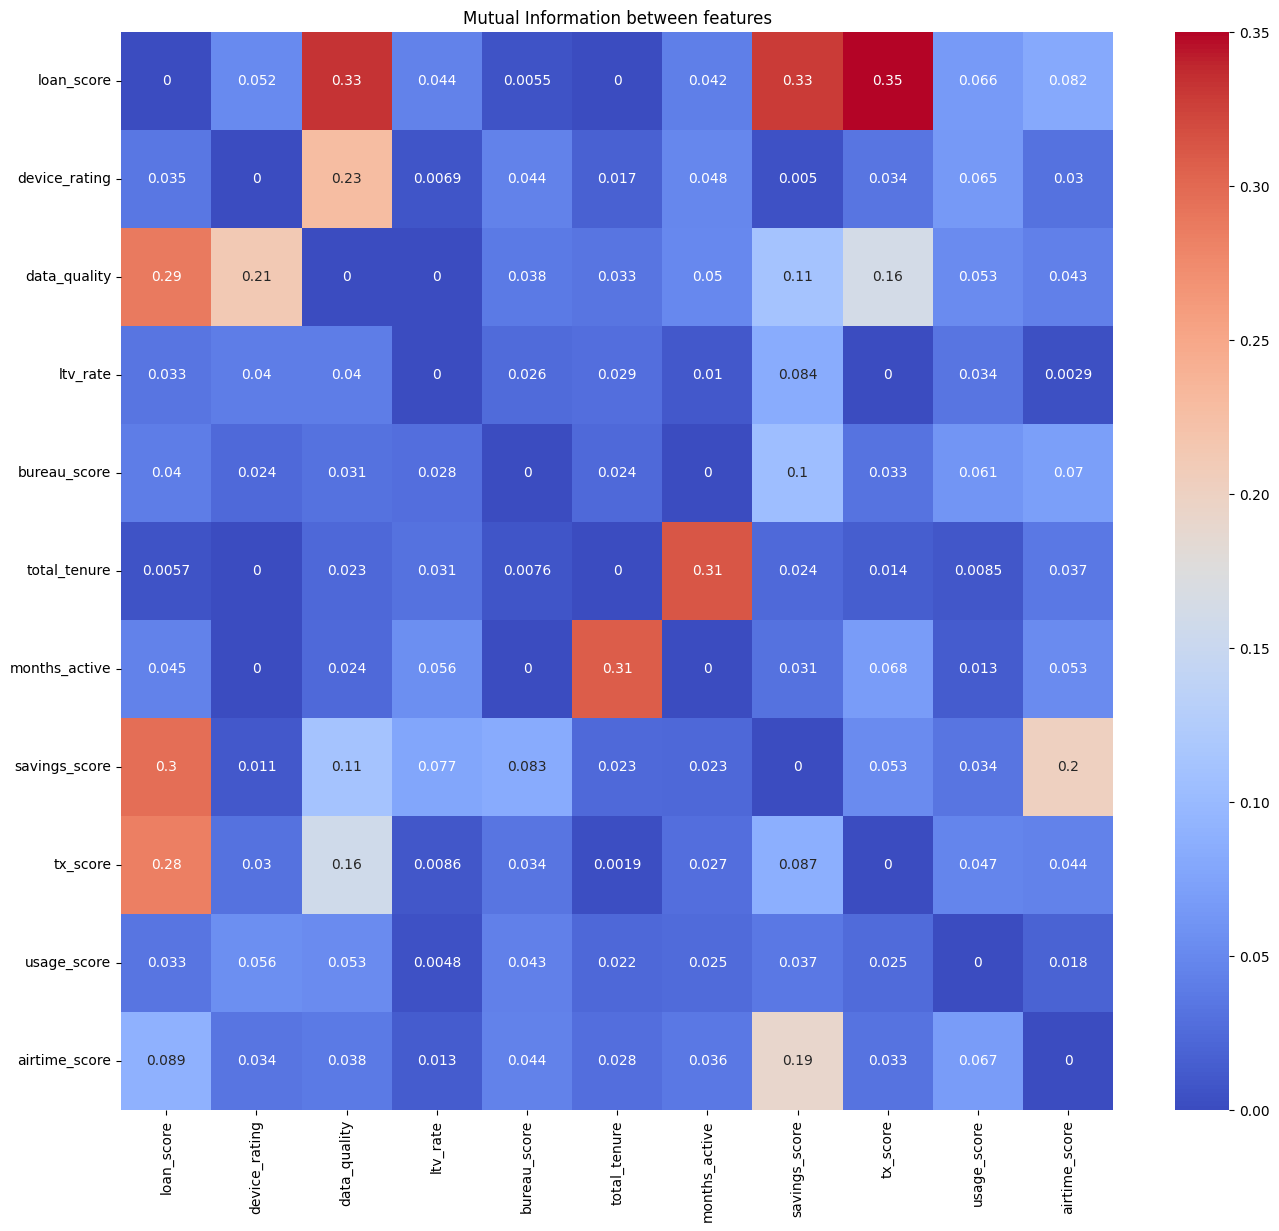

In [20]:
plt.figure(figsize=(16, 14))
sns.heatmap(mi_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Mutual Information between features')
plt.show()

## Multivariate Analysis

### Dimensionality Reduction Analysis

#### Principal Component Analysis (PCA) Visualization

In [21]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_copy_scaled)
pca_df = pd.DataFrame(pca_data, columns=["PCA1", "PCA2"])
pca_df

,PCA1,PCA2
0,-1.619530,0.450950
1,-0.799170,1.856553
2,-0.748479,0.882039
3,2.357673,-0.269976
4,-1.619530,0.450950
...,...,...
1594,-2.150500,0.814286
1595,-2.214496,0.893101
1596,-1.456129,0.311746
1597,-2.270518,0.979791


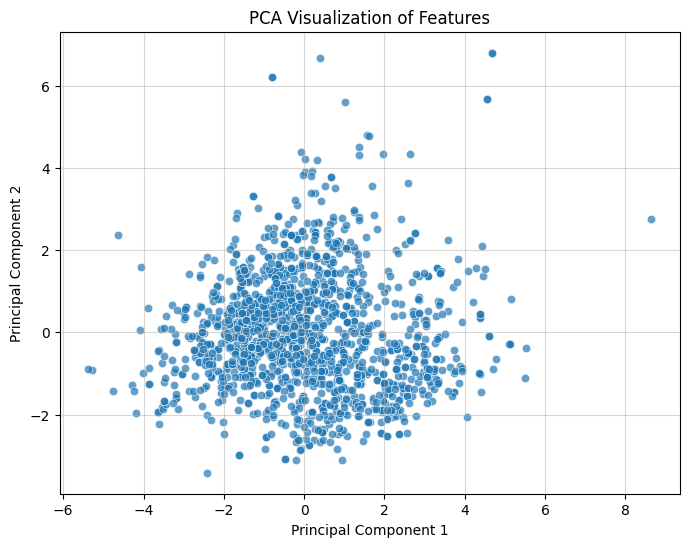

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PCA1",
    y="PCA2",
    alpha=0.7
)

plt.title("PCA Visualization of Features", fontsize=12)
plt.xlabel("Principal Component 1", fontsize=10)
plt.ylabel("Principal Component 2", fontsize=10)
plt.grid(alpha=0.5)
plt.show()

Determining the explained variance and the total explained variance for the PCA components (PCA1 and PCA2)

In [23]:
explained_variance_ratio_pca = pca.explained_variance_ratio_
explained_variance_percentage_pca = np.round(explained_variance_ratio_pca * 100, 2)
total_explained_variance_pca = np.round((np.sum(explained_variance_ratio_pca) * 100), 2)

print(f"Explained Variance for PCA1: {explained_variance_percentage_pca[0]}%")
print(f"Explained Variance for PCA2: {explained_variance_percentage_pca[1]}%")
print(f"Total Explained Variance: {total_explained_variance_pca}%")

Explained Variance for PCA1: 28.17%
Explained Variance for PCA2: 17.51%
Total Explained Variance: 45.68%


#### t-Distributed Stochastic Neighbor Embedding (t-SNE) Evaluation using Trustworthiness 

In [24]:
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000,
)
tsne_data = tsne.fit_transform(df_copy_scaled)
tsne_df = pd.DataFrame(tsne_data, columns=["TSNE1", "TSNE2"])
tsne_df

,TSNE1,TSNE2
0,-41.913094,17.466972
1,-22.455278,33.276535
2,-22.422318,31.697754
3,36.404175,1.544825
4,-41.782364,17.822237
...,...,...
1594,-20.646160,-23.200743
1595,-16.149492,-22.432693
1596,-18.023481,-20.575600
1597,-20.140306,-25.619781


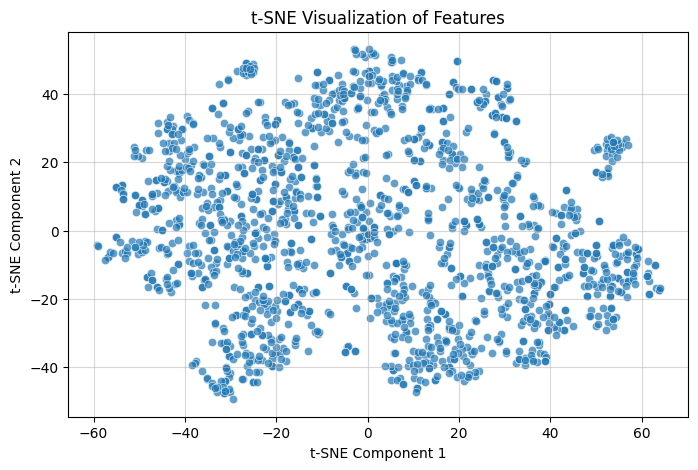

In [25]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1",
    y="TSNE2",
    alpha=0.7
)

plt.title("t-SNE Visualization of Features", fontsize=12)
plt.xlabel("t-SNE Component 1", fontsize=10)
plt.ylabel("t-SNE Component 2", fontsize=10)
plt.grid(alpha=0.5)
plt.show()

#### t-SNE Evaluation using Trustworthiness and Optimum Scaling Factor Determination

In [26]:
df_copy_scaled.shape[0]

1599

In [27]:
scaling_factors = [0.1, 0.2, 0.3, 0.4, 0.5]
cluster_size = df_copy_scaled.shape[0] // 5 # Aiming for 5 clusters (user profiles)
k_values = [int(cluster_size * sf) for sf in scaling_factors]
trust_scores = [trustworthiness(df_copy_scaled, tsne_df, n_neighbors=k) for k in k_values]

In [28]:
k_values

[31, 63, 95, 127, 159]

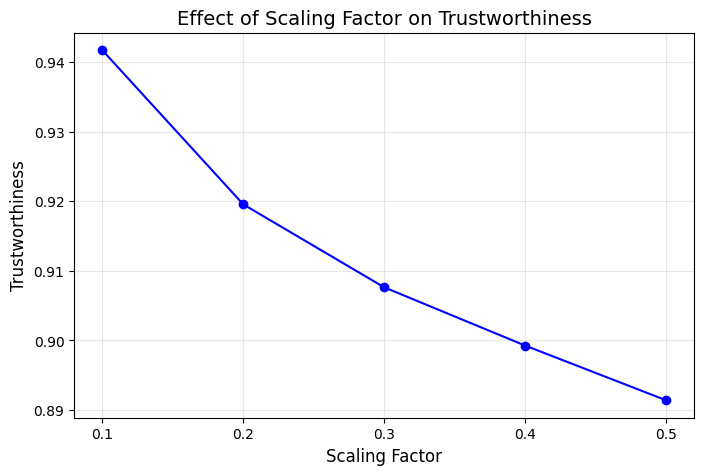

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(scaling_factors, trust_scores, marker='o', linestyle='-', color='b')
plt.title("Effect of Scaling Factor on Trustworthiness", fontsize=14)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Trustworthiness", fontsize=12)
plt.xticks(scaling_factors)
plt.grid(alpha=0.3)
plt.show()

Determining the optimum value for k

In [30]:
optimum_k = k_values[np.argmax(trust_scores)]
optimum_k

31

In [31]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(tsne_df)
tsne_df["Cluster"] = clusters
tsne_df

,TSNE1,TSNE2,Cluster
0,-41.913094,17.466972,0
1,-22.455278,33.276535,0
2,-22.422318,31.697754,0
3,36.404175,1.544825,2
4,-41.782364,17.822237,0
...,...,...,...
1594,-20.646160,-23.200743,3
1595,-16.149492,-22.432693,3
1596,-18.023481,-20.575600,3
1597,-20.140306,-25.619781,3


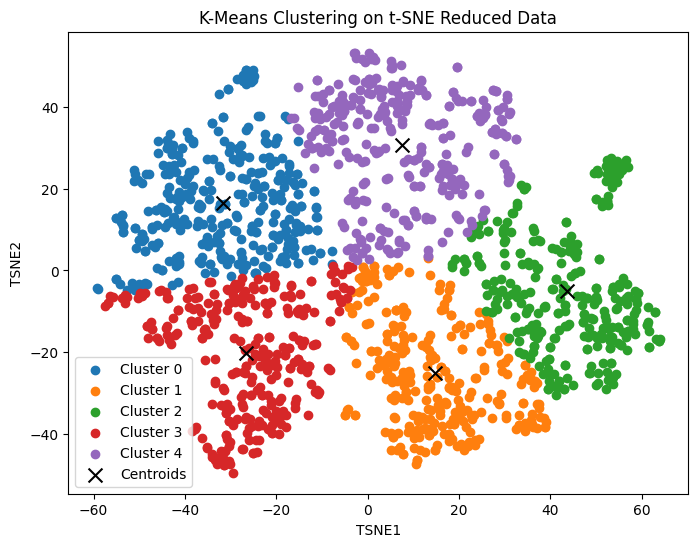

In [34]:
plt.figure(figsize=(8, 6))
for cluster in range(5):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f"Cluster {cluster}")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title("K-Means Clustering on t-SNE Reduced Data")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.show()